In [1]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import os
from PCA_NP import pca_np

In [2]:
import torch
from sam2.build_sam import build_sam2
from sam2.sam2_image_predictor import SAM2ImagePredictor
import cv2

In [3]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cuda device


In [4]:
sam2_checkpoint = "../../sam2/checkpoints/sam2.1_hiera_tiny.pt"
model_cfg = "configs/sam2.1/sam2.1_hiera_t.yaml"

sam2_model = build_sam2(model_cfg, sam2_checkpoint, device=device)

predictor = SAM2ImagePredictor(sam2_model)

In [5]:
#read all images from the folder
def read_images(folder):
    images = {}
    for filename in os.listdir(folder):
        img = Image.open(os.path.join(folder, filename))
        if img is not None:
            images[filename.split('.')[0]] = img
    return images

In [6]:
folder_images = '../../data/kvasir-seg/Kvasir-SEG-processed/val/images'
folder_masks = '../../data/kvasir-seg/Kvasir-SEG-processed/val/masks'

In [7]:
images = read_images(folder_images)
masks = read_images(folder_masks)

In [8]:
#images['cju7ejm2l2ncl0801wq6y84nw']

In [9]:
#masks['cju7ejm2l2ncl0801wq6y84nw']

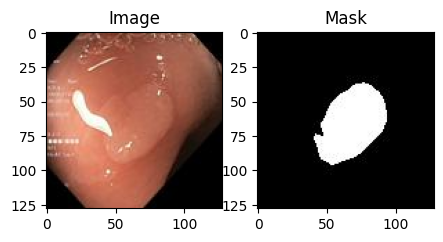

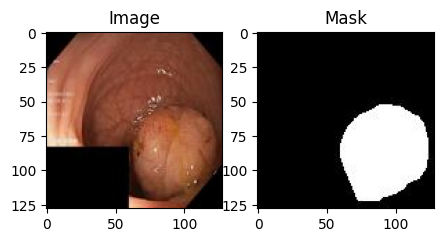

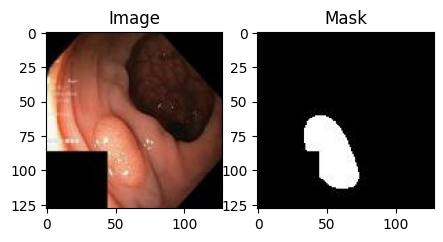

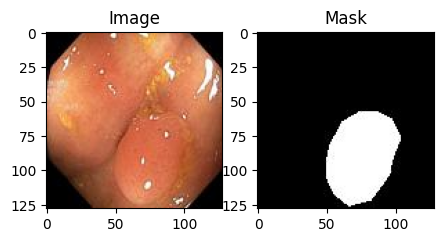

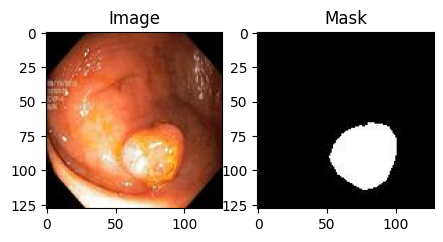

In [10]:
# plot the image and mask
def plot_image_mask(image, mask):
    fig, axs = plt.subplots(1, 2, figsize=(5, 5))
    axs[0].imshow(image)
    axs[0].set_title('Image')
    axs[1].imshow(mask)
    axs[1].set_title('Mask')
    plt.show()
    

#plot the first 5 images
for name in list(images.keys())[:5]:
    plot_image_mask(images[name], masks[name])

In [11]:
# apply PCA to the images
images_pca = {}
for name, img in images.items():
    matrices, explained_var_scores = pca_np(np.array(img))
    images_pca[name] = (matrices, explained_var_scores, images[name])

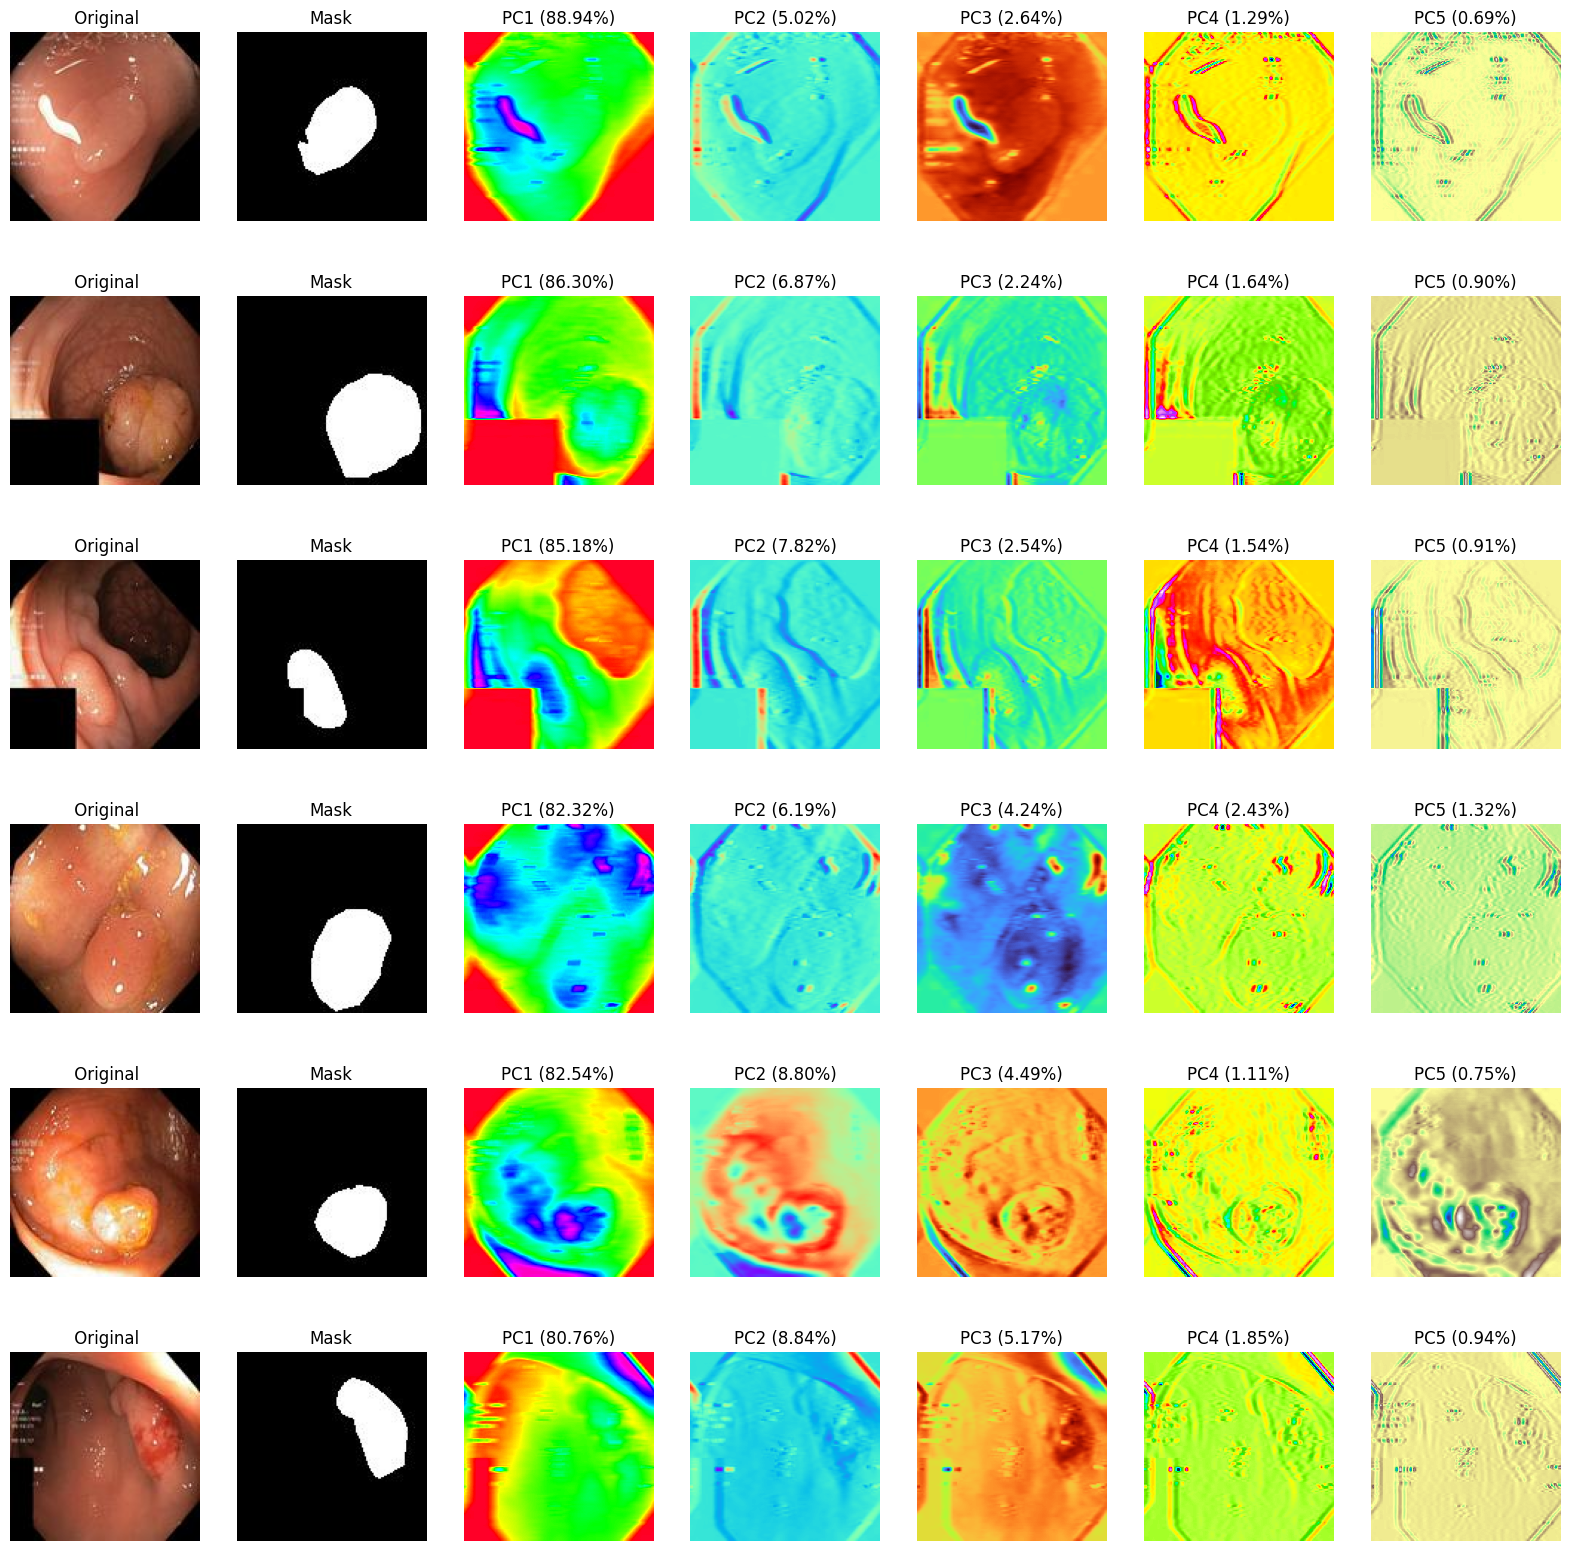

In [12]:
# plot the pca_np image
fig, ax = plt.subplots(6, 7, figsize=(20, 20))
colors = ['gist_rainbow', 'rainbow', 'turbo', 'gist_ncar', 'terrain']
for i, (name, (matrices, scores, original)) in enumerate(images_pca.items()):
    ax[i, 0].imshow(original)
    ax[i, 0].axis('off')
    ax[i, 0].set_title(' Original')
    # add mask
    mask = masks[name]
    ax[i, 1].imshow(mask)
    ax[i, 1].axis('off')
    ax[i, 1].set_title('Mask')
    for j, matrix in enumerate(matrices):
        ax[i, j+2].imshow(matrix, cmap=colors[j])
        ax[i, j+2].axis('off')
        ax[i, j+2].set_title(f'PC{j+1} ({scores[j]:.2f}%)')
    if i == 5:
        break
plt.show()

In [13]:
dict_results = {}
for name, img in images.items():
    dict_results[name] = {}
    predictor.set_image(np.array(img))
    for i, (_, (matrices, _, _)) in enumerate(images_pca.items()):
        for j, matrix in enumerate(matrices):
            matrix_sam_fixed = np.zeros((1, 256, 256))  # Initialize the new array
            matrix_sam_fixed[0] = cv2.resize(matrix, (256, 256), interpolation=cv2.INTER_LINEAR)
            masks, scores, _ = predictor.predict(mask_input = matrix_sam_fixed, multimask_output=True)
            sorted_ind = np.argsort(scores)[::-1]
            masks = masks[sorted_ind]
            mask = masks[0]
            #mask, _, _ = predictor.predict(mask_input = matrix_sam_fixed, multimask_output=False)
            mask = np.array(mask).astype(np.float32)
            dict_results[name][f'mask_from_pca_{j+1}'] = mask

In [14]:
dict_results_points = {}
n_points_div2 = 10
for name, img in images.items():
    dict_results_points[name] = {}
    predictor.set_image(np.array(img))
    for i, (_, (matrices, _, _)) in enumerate(images_pca.items()):
        for j, matrix in enumerate(matrices):
            #mean_value = np.mean(matrix)
            #matrix[matrix < mean_value] = 0
            #matrix[matrix > mean_value] = 1
            # Flatten the matrix to work with probabilities
            flattened_matrix = matrix.flatten()
            # Normalize the pixel values to create probabilities
            probabilities_foreground = flattened_matrix / np.sum(flattened_matrix)
            # Get the indices of 10 randomly selected points, with higher probabilities for larger values
            selected_indices_foreground = np.random.choice(len(flattened_matrix), size=n_points_div2, replace=False, p=probabilities_foreground)
            # Convert the flattened indices back to 2D coordinates
            selected_points_foreground = np.array(np.unravel_index(selected_indices_foreground, matrix.shape)).T

            inverted_values = 1.0 - flattened_matrix
            probabilities_background = inverted_values / np.sum(inverted_values)
            selected_indices_background = np.random.choice(len(inverted_values), size=n_points_div2, replace=False, p=probabilities_background)
            selected_points_background = np.array(np.unravel_index(selected_indices_background, matrix.shape)).T

            selected_points = np.vstack((selected_points_foreground, selected_points_background))


            input_label = np.array([1] * n_points_div2 + [0] * n_points_div2) # foreground points + background points

            masks, scores, _ = predictor.predict(
                point_coords=selected_points,
                point_labels=input_label, multimask_output=True)
            sorted_ind = np.argsort(scores)[::-1]
            masks = masks[sorted_ind]
            mask = masks[0]
            mask = np.array(mask).astype(np.float32)
            dict_results_points[name][f'mask_from_pca_{j+1}'] = mask

In [15]:
dict_results_clip = {}
for name, img in images.items():
    dict_results_clip[name] = {}
    predictor.set_image(np.array(img))
    for i, (_, (matrices, _, _)) in enumerate(images_pca.items()):
        for j, matrix in enumerate(matrices):
            mean_value = np.mean(matrix)
            matrix[matrix < mean_value] = 0
            matrix[matrix > mean_value] = 1
            matrix_sam_fixed = np.zeros((1, 256, 256))  # Initialize the new array
            matrix_sam_fixed[0] = cv2.resize(matrix, (256, 256), interpolation=cv2.INTER_LINEAR)
            masks, scores, _ = predictor.predict(mask_input = matrix_sam_fixed, multimask_output=True)
            sorted_ind = np.argsort(scores)[::-1]
            masks = masks[sorted_ind]
            mask = masks[0]
            #mask, _, _ = predictor.predict(mask_input = matrix_sam_fixed, multimask_output=False)
            mask = np.array(mask).astype(np.float32)
            dict_results_clip[name][f'mask_from_pca_{j+1}'] = mask

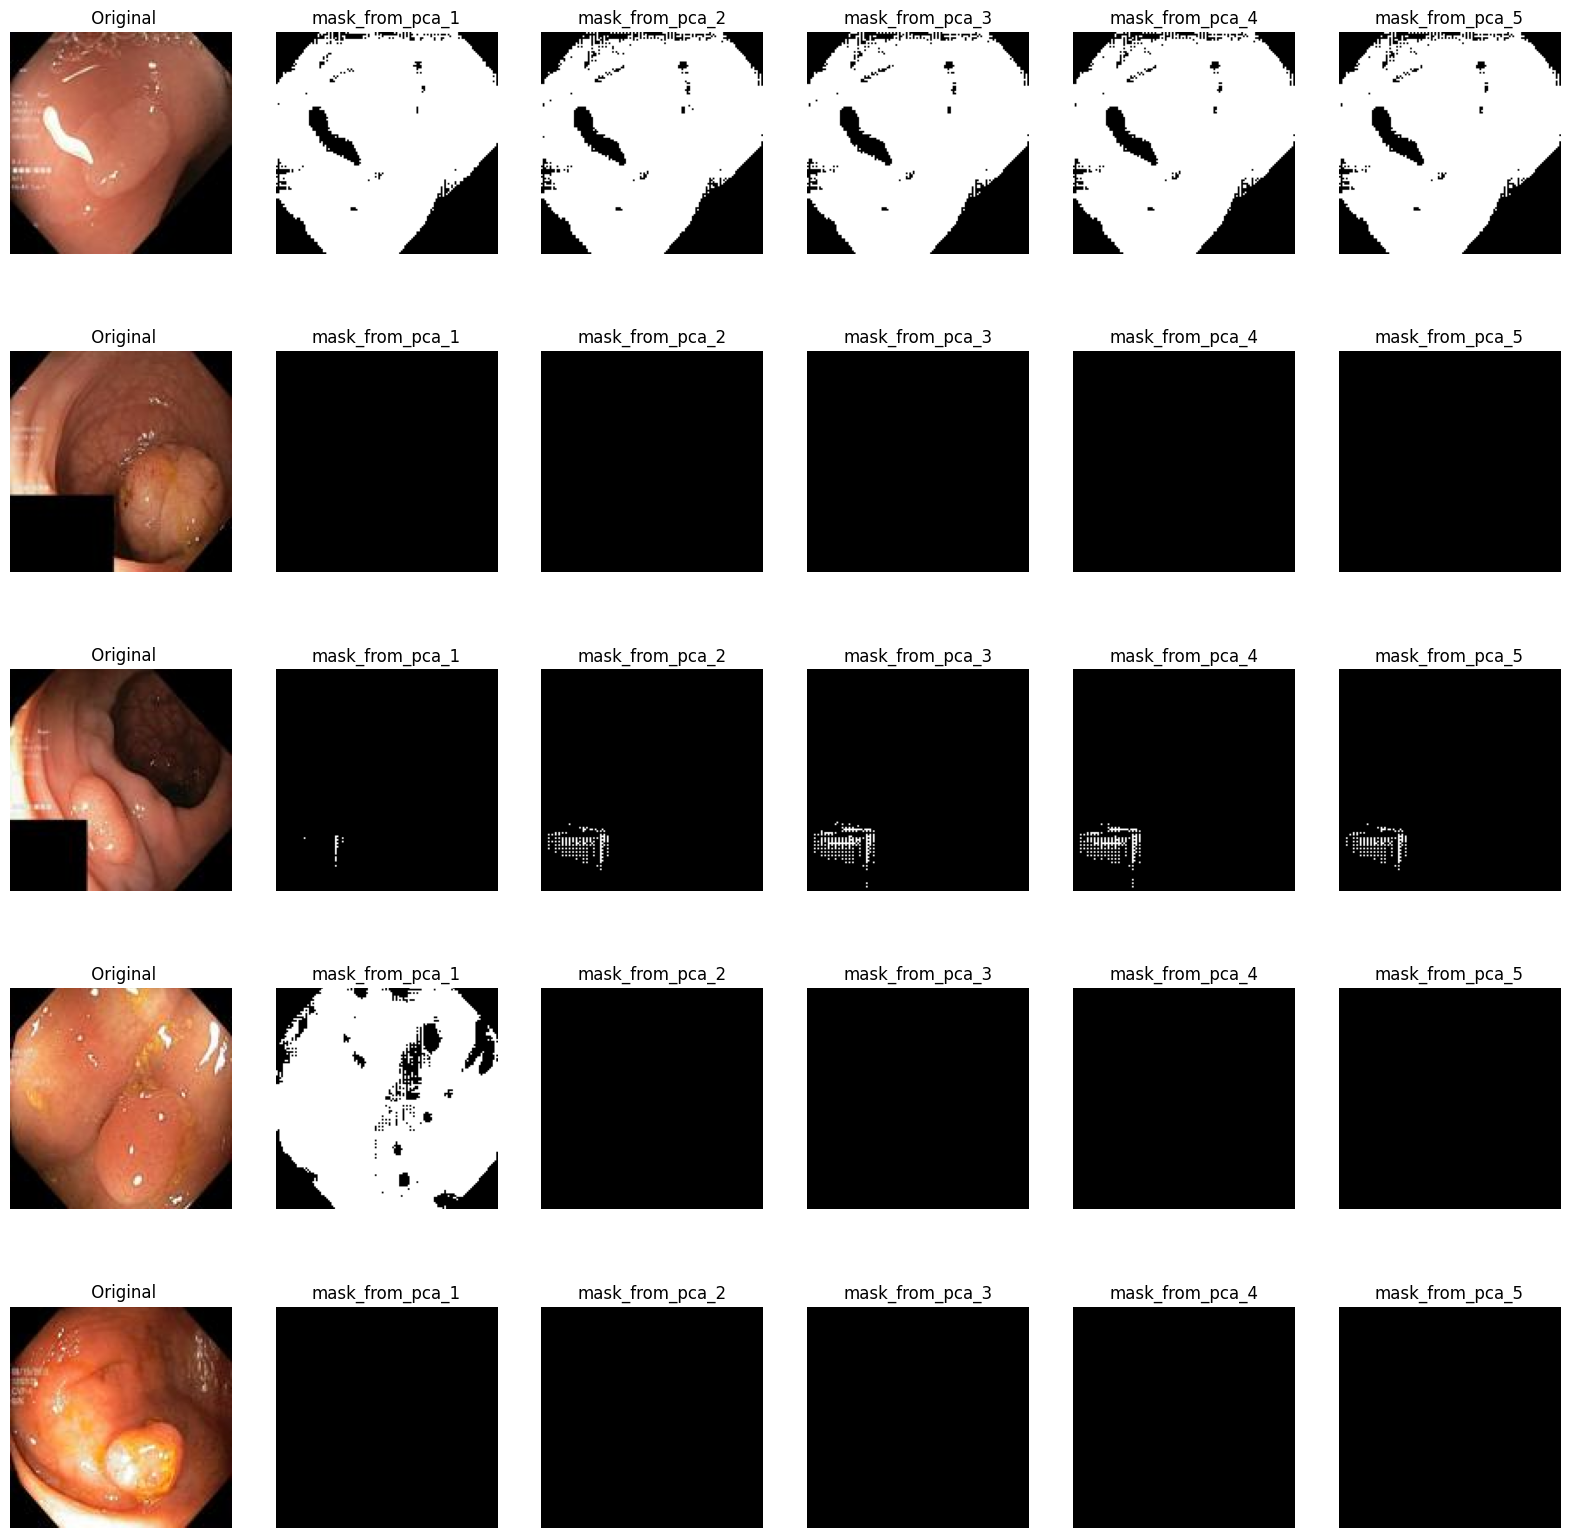

In [16]:
# plot for the first 5 images the mask for each pca component
fig, ax = plt.subplots(5, 6, figsize=(20, 20))
for i, (name, masks) in enumerate(list(dict_results.items())[:5]):
    ax[i, 0].imshow(images_pca[name][2])
    ax[i, 0].axis('off')
    ax[i, 0].set_title(' Original')
    for j, (component, mask) in enumerate(masks.items()):
        ax[i, j+1].imshow(mask, cmap='grey')
        ax[i, j+1].axis('off')
        ax[i, j+1].set_title(f'{component}')
plt.show()

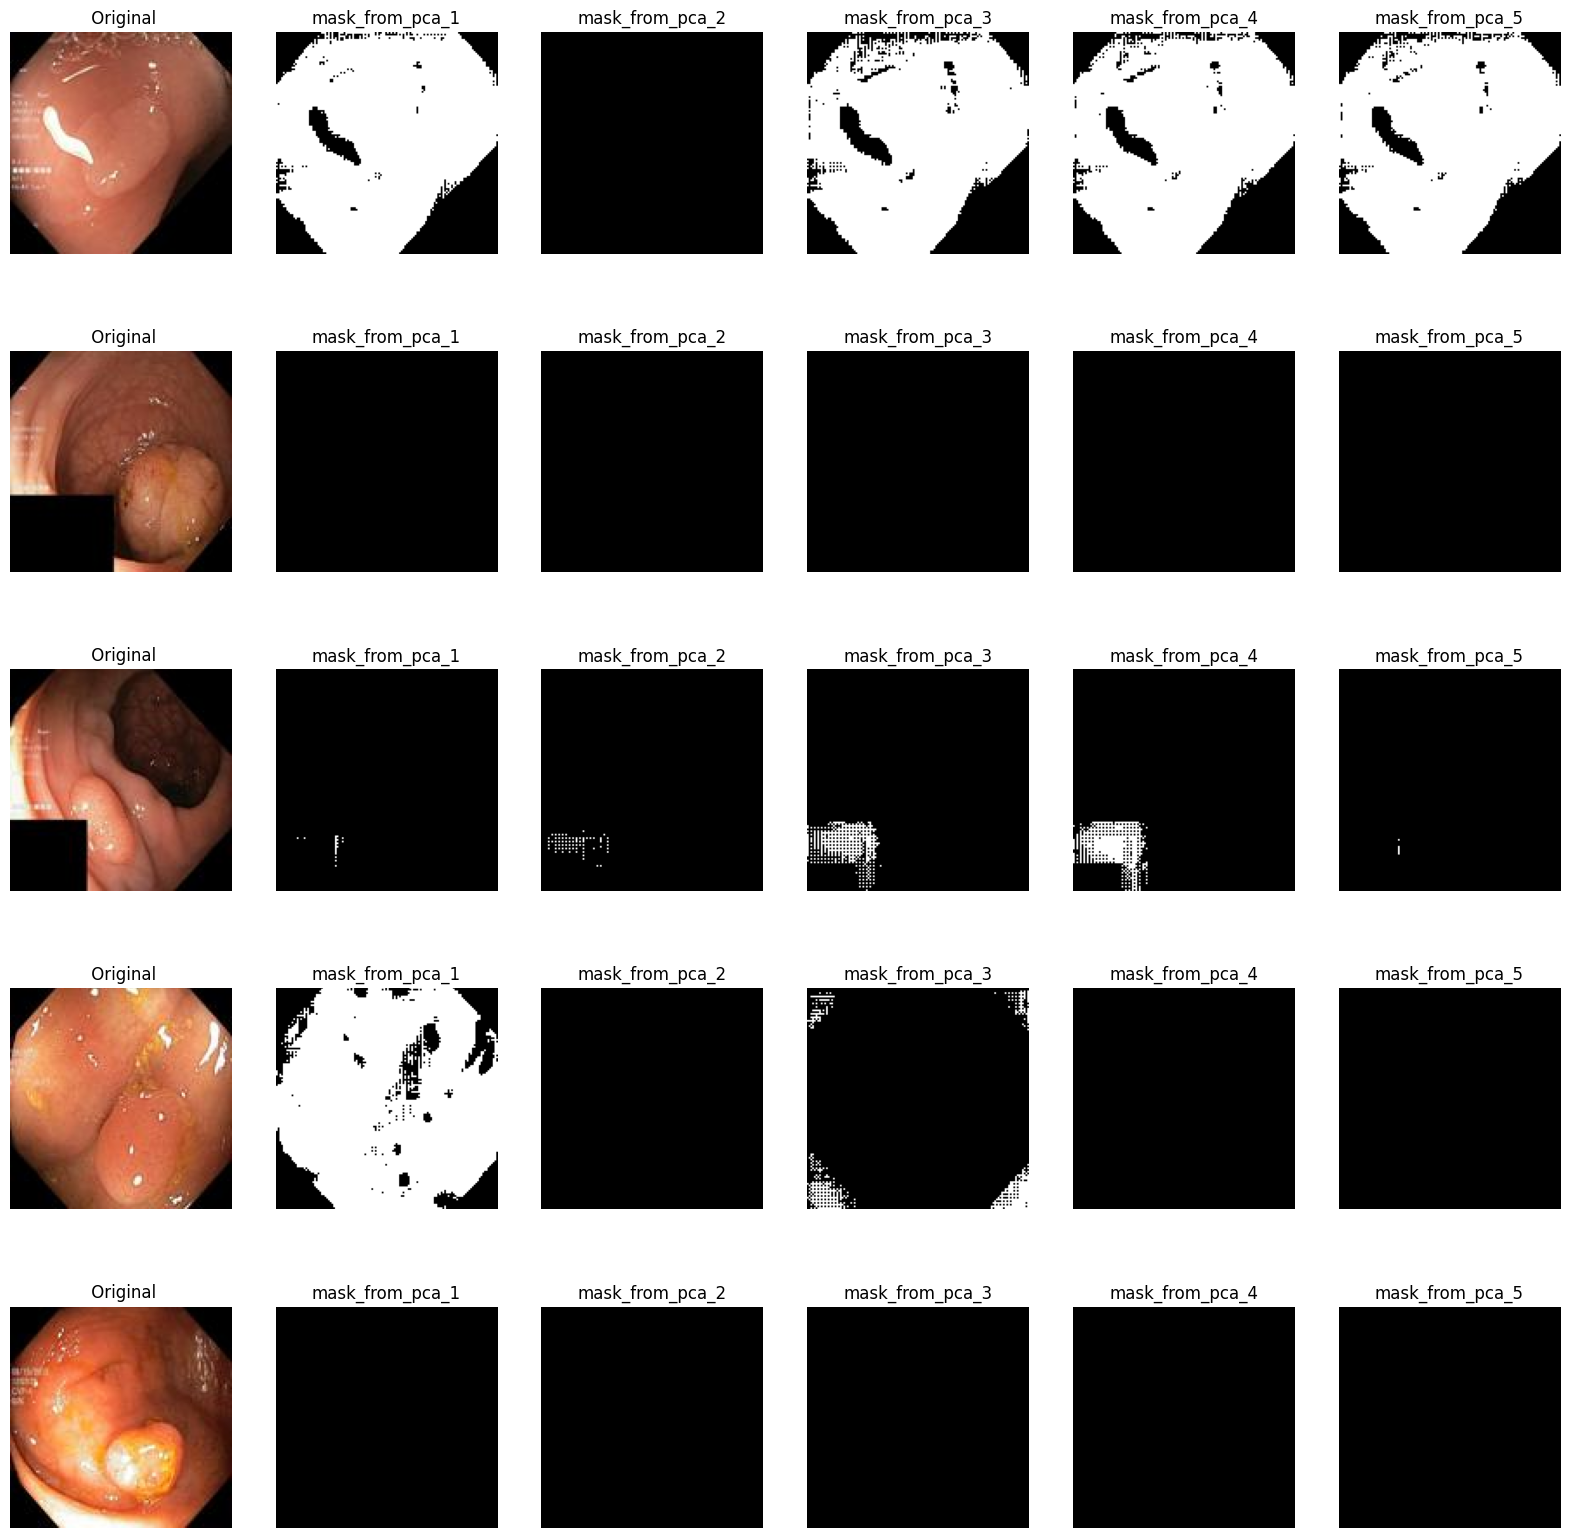

In [17]:
fig, ax = plt.subplots(5, 6, figsize=(20, 20))
for i, (name, masks) in enumerate(list(dict_results_clip.items())[:5]):
    ax[i, 0].imshow(images_pca[name][2])
    ax[i, 0].axis('off')
    ax[i, 0].set_title(' Original')
    for j, (component, mask) in enumerate(masks.items()):
        ax[i, j+1].imshow(mask, cmap='grey')
        ax[i, j+1].axis('off')
        ax[i, j+1].set_title(f'{component}')
plt.show()

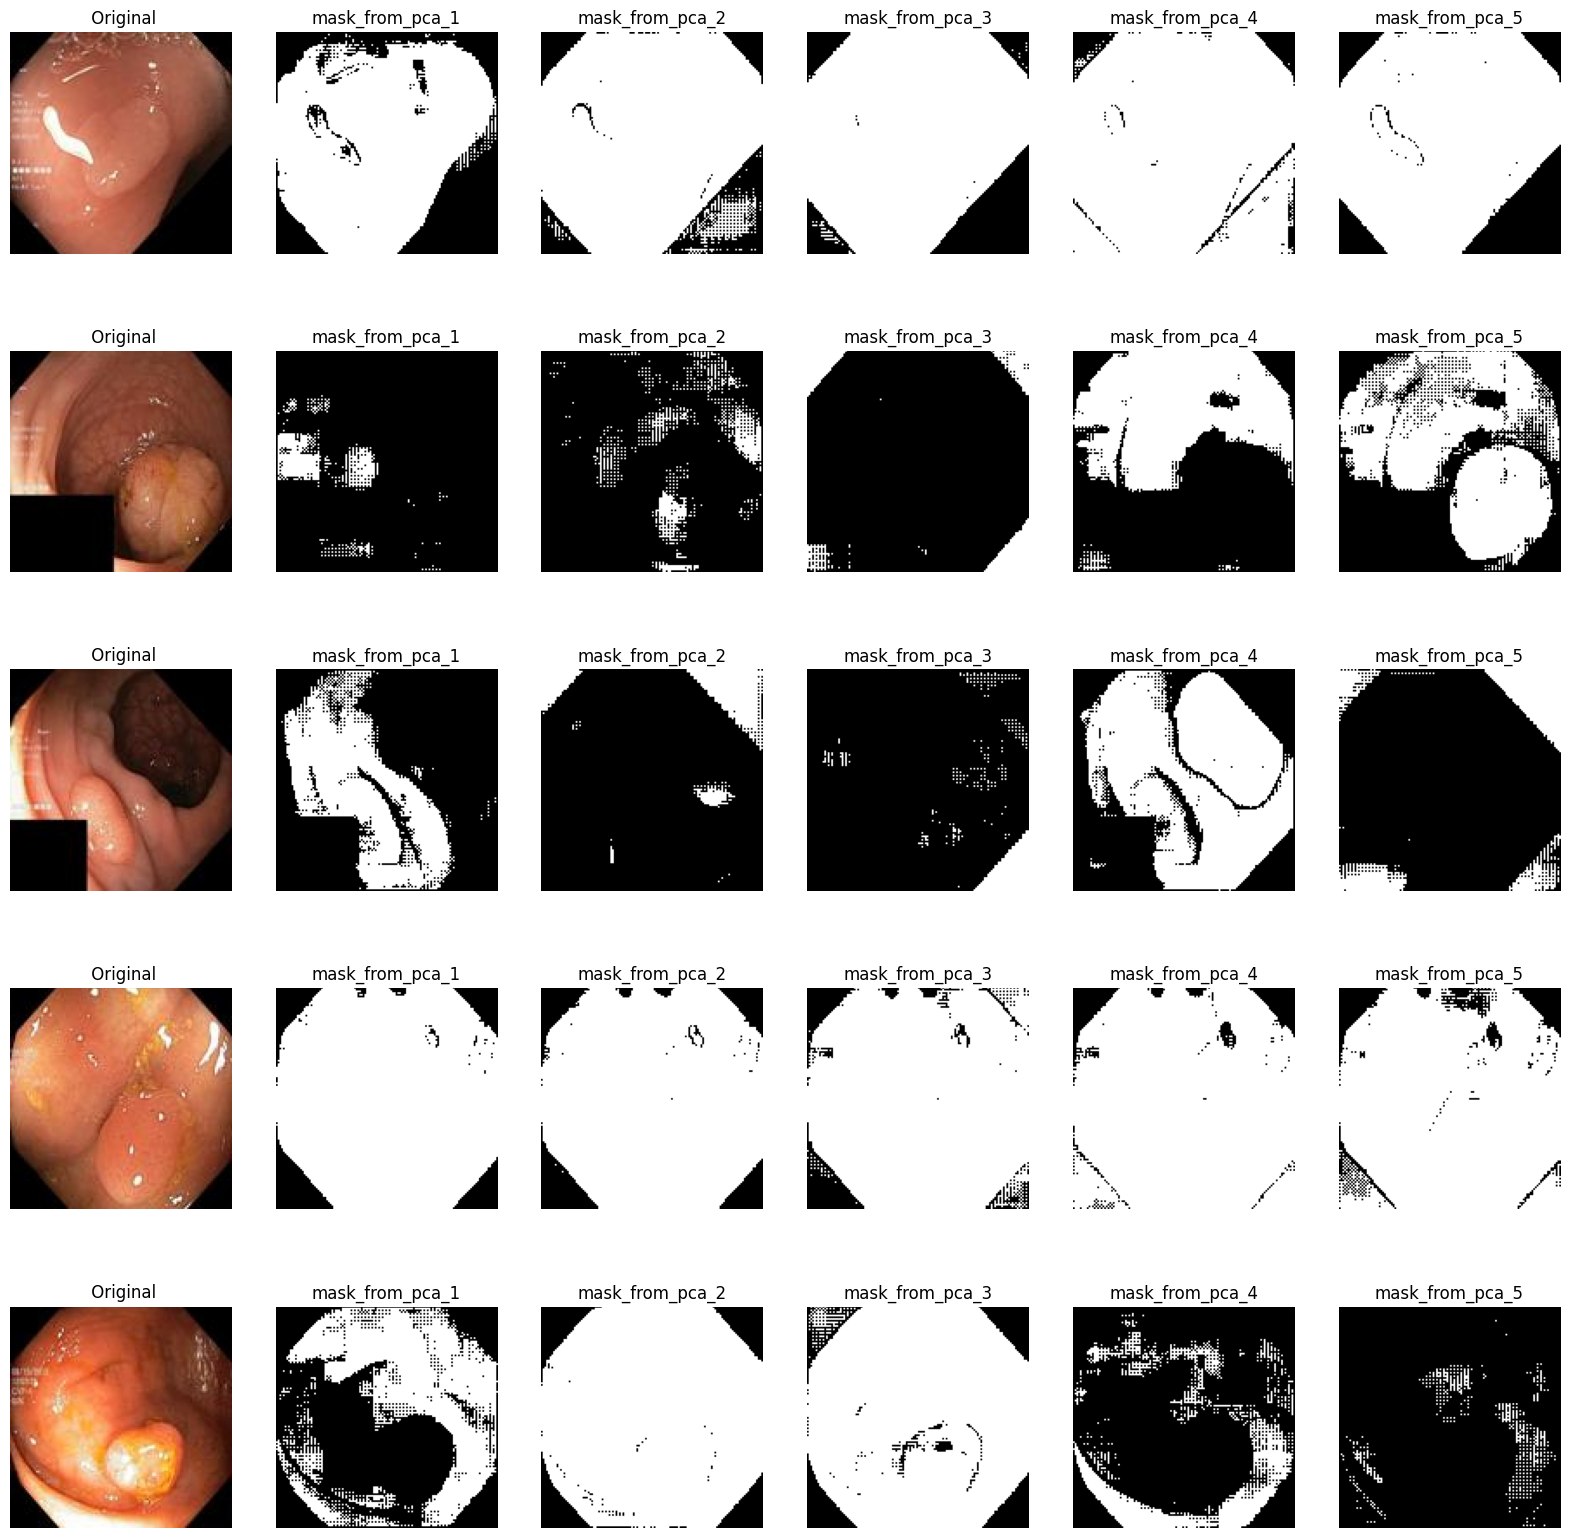

In [18]:
fig, ax = plt.subplots(5, 6, figsize=(20, 20))
for i, (name, masks) in enumerate(list(dict_results_points.items())[:5]):
    ax[i, 0].imshow(images_pca[name][2])
    ax[i, 0].axis('off')
    ax[i, 0].set_title(' Original')
    for j, (component, mask) in enumerate(masks.items()):
        ax[i, j+1].imshow(mask, cmap='grey')
        ax[i, j+1].axis('off')
        ax[i, j+1].set_title(f'{component}')
plt.show()